# Laboratorio di simulazione numerica

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import string
from scipy.optimize import curve_fit

### Exercise 07.1

In [4]:
prefix = "exercise07-1/"

###### Warm-up period analysis
I compare two runs of the simulator in order to estimate the equilibration time.
I ran the program with two different seeds for the random number generator and with different initial configurations, and output the values of the potential energy in the two cases.
To obtain the results for this part, run `./warmup-analysis warmup` while in the `exercise07-1` directory.

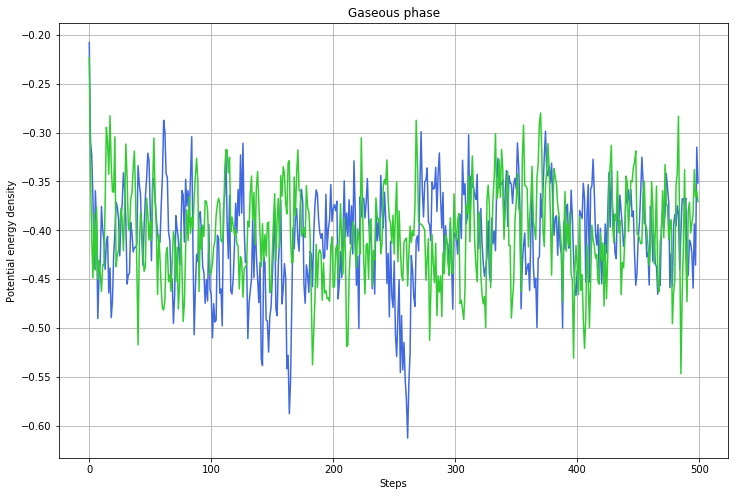

In [6]:
u1, u2 = np.loadtxt(prefix + "warmup_analysis_output.dat", unpack = True)

plt.figure(figsize = (12, 8))
max_steps = 500
plt.title('Gaseous phase')
plt.xlabel('Steps')
plt.ylabel('Potential energy density')
plt.plot(range(max_steps), u1[:max_steps], color = "royalblue")
plt.plot(range(max_steps), u2[:max_steps], color = "limegreen")
plt.grid(True)
plt.show()

It would seem that 200 steps are well enough for the initial transient effects to vanish.

##### Autocorrelation

Having set the amount of equilibration steps to 200, I now analyse the autocorrelation of the data generated by the Metropolis algorithm.
I will fit an exponential function to the autocorrelation series obtained by the data in order to find the autocorrelation time.

Running `./exercise07-1 phase` while in the `exercise07-1` directory (`phase` may be `gaseous`, `liquid` or `solid`) generates the data relative to a specific phase of the system, which is modelled with a Lennard-Jones potential using the parameters in the table below.
If you wish to run everything at once, launch `./run_all.sh`

<table>
    <tr>
        <th style="text-align: center">Gaseous phase</th>
        <th style="text-align: center">Liquid phase</th>
        <th style="text-align: center">Solid phase</th>
    </tr>
    <tr>
        <td><table>
            <tr>
                <th>Quantity</th><th>Value</th>
            </tr>
            <tr>
                <td>Particle density</td><td>0.05</td>
            </tr>
            <tr>
                <td>Temperature</td><td>1.2</td>
            </tr>
            <tr>
                <td>Cut-off radius</td><td>5.0</td>
            </tr>
        </table></td>
        <td><table>
            <tr>
                <th>Quantity</th><th>Value</th>
            </tr>
            <tr>
                <td>Particle density</td><td>0.8</td>
            </tr>
            <tr>
                <td>Temperature</td><td>1.1</td>
            </tr>
            <tr>
                <td>Cut-off radius</td><td>2.5</td>
            </tr>
            </table></td>
        <td><table>
            <tr>
                <th>Quantity</th><th>Value</th>
            </tr>
            <tr>
                <td>Particle density</td><td>1.1</td>
            </tr>
            <tr>
                <td>Temperature</td><td>0.8</td>
            </tr>
            <tr>
                <td>Cut-off radius</td><td>2.2</td>
            </tr>
            </table></td>
    </tr>
</table>

In [8]:
def autocovariance(series, lag):
    n = len(series)
    mean = 0
    for x in series:
        mean += x
    mean /= n
    c = 0
    for i in range(n - lag):
        c += (series[i] - mean)*(series[i + lag] - mean)
    return c / n

def autocorrelation(series, lag):
    return autocovariance(series, lag) / autocovariance(series, 0)

def autocorrelation_fit(t, t0):
    return [np.exp(-x / t0) for x in t]
    # curve_fit from scipy expects the function to be vectorised.

The estimates of the autocorrelation time for the gaseous phase results are 7.8065304051709505 and 1.8417419788871492
The estimates of the autocorrelation time for the liquid phase results are 20.54426984373059 and 26.910777126055983
The estimates of the autocorrelation time for the solid phase results are 19.408173470933093 and 19.083452876151224


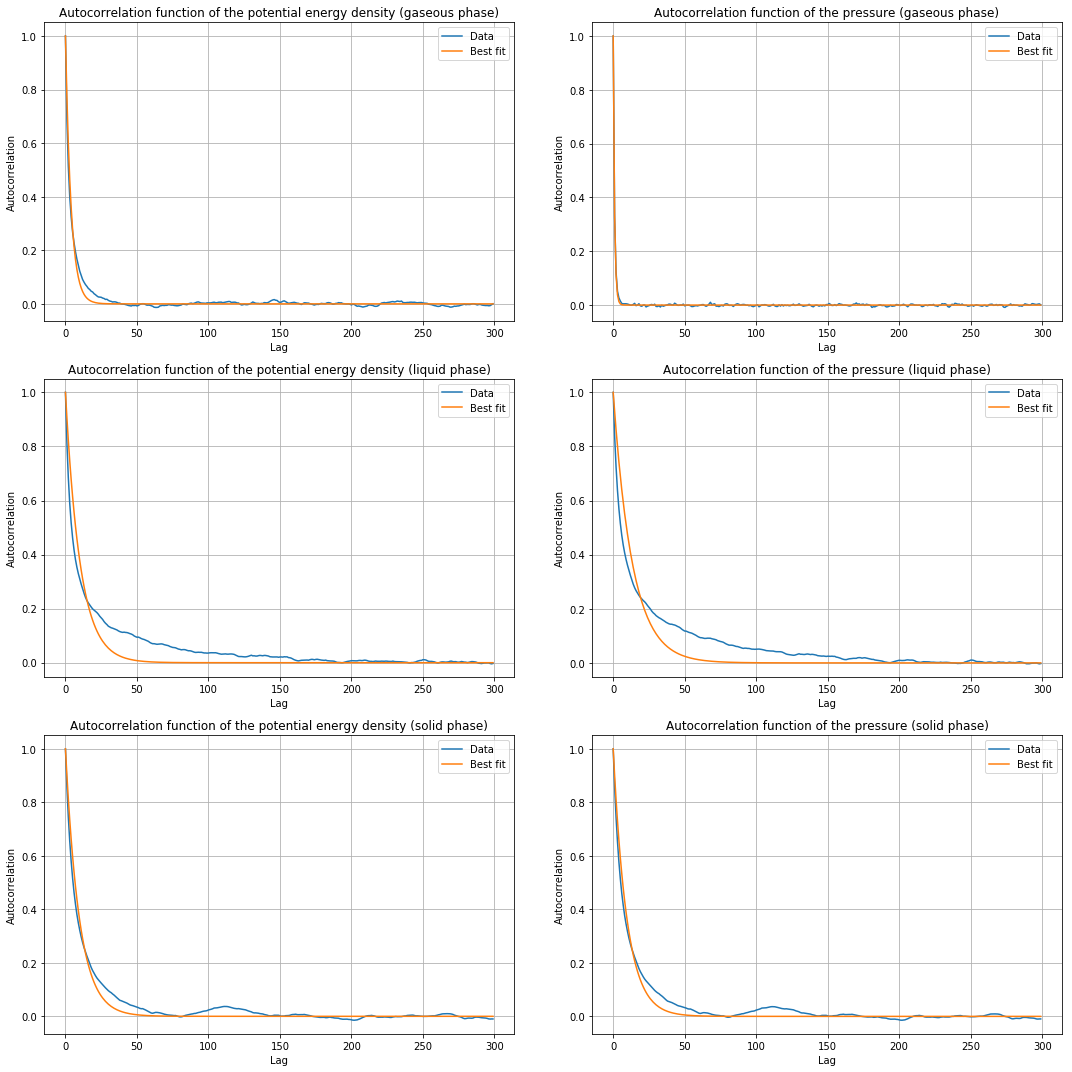

In [12]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 15))
axes = axes.flatten()
phases = ["gaseous", "liquid", "solid"]

for plot_count, phase in enumerate(phases):
    u, p = np.loadtxt(prefix + phase + "_output.dat", unpack = True)
    max_lag = 300

    u_acf = [autocorrelation(u, t) for t in range(max_lag)]
    p_acf = [autocorrelation(p, t) for t in range(max_lag)]

    u_autocorrelation_time, u_variance = curve_fit(autocorrelation_fit, range(max_lag), u_acf, p0 = 1)
    p_autocorrelation_time, p_variance = curve_fit(autocorrelation_fit, range(max_lag), p_acf, p0 = 1)
    
    axes[2 * plot_count].grid(True)
    axes[2 * plot_count].set_title("Autocorrelation function of the potential energy density (" + phase + " phase)")
    axes[2 * plot_count].set_xlabel("Lag")
    axes[2 * plot_count].set_ylabel("Autocorrelation")
    axes[2 * plot_count].plot(u_acf, label = "Data")
    axes[2 * plot_count].plot(autocorrelation_fit(range(max_lag), u_autocorrelation_time[0]), label = "Best fit")
    axes[2 * plot_count].legend()

    axes[2 * plot_count + 1].grid(True)
    axes[2 * plot_count + 1].set_title("Autocorrelation function of the pressure (" + phase + " phase)")
    axes[2 * plot_count + 1].set_xlabel("Lag")
    axes[2 * plot_count + 1].set_ylabel("Autocorrelation")
    axes[2 * plot_count + 1].plot(p_acf, label = "Data")
    axes[2 * plot_count + 1].plot(autocorrelation_fit(range(max_lag), p_autocorrelation_time[0]), label = "Best fit")
    axes[2 * plot_count + 1].legend()
    
    print("The estimates of the autocorrelation time for the " + phase + " phase results are " + str(2 * u_autocorrelation_time[0]) + " and " + str(2 * p_autocorrelation_time[0]))

fig.tight_layout()
plt.show()

For each phase of the system I have two estimates of the autocorrelation time: I will take twice the maximum of the two as a "safe estimate" of the parameter, that is:
- 16 steps for the gaseous phase,
- 54 steps for the liquid phase,
- 40 steps for the solid phase.

###### Study of the statistical uncertainty

I study the expectation value of the potential energy density and the pressure (reusing the data generated for the autocorrelation plots above) as the size of the blocks is varied from 10 to 5000.

In [15]:
# This function is the usual function that computes an array
# of average values and an array of the associated standard
# deviations, using a blocking technique.
def block_uncertainty(series, block_length):
    n_blocks = int(len(series) / block_length)
    mean  = np.zeros(n_blocks)
    stdev = np.zeros(n_blocks)
    sum_avg    = 0
    sum_sq_avg = 0
    for i in range(n_blocks):
        block_avg = 0
        for j in range(block_length):
            block_avg += series[block_length * i + j]
        block_avg  /= block_length
        sum_avg    += block_avg
        sum_sq_avg += block_avg**2
        mean[i]     = sum_avg / (i + 1)
        if i > 0:
            stdev[i] = np.sqrt((sum_sq_avg / (i + 1) - mean[i]**2) / i)
    return mean, stdev

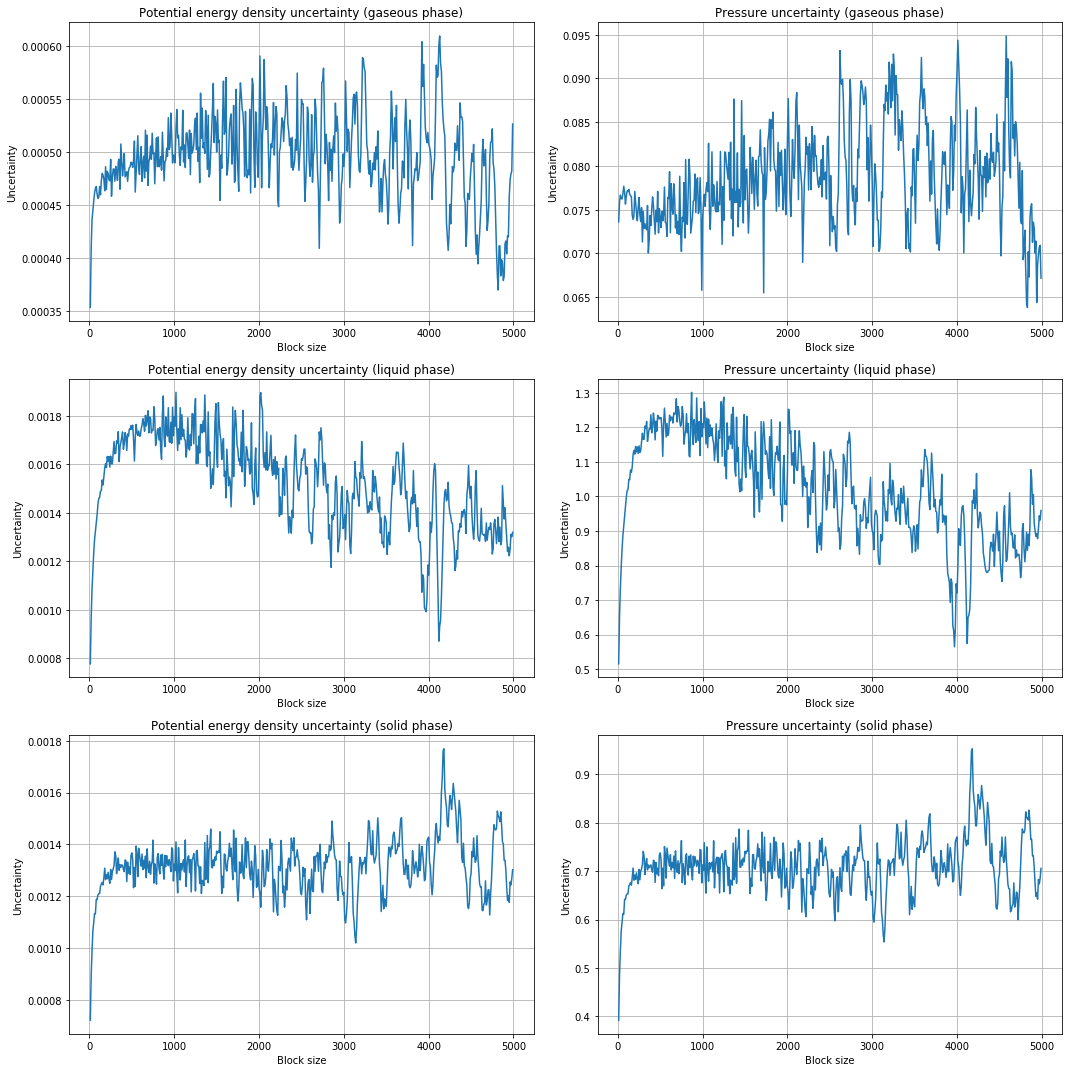

In [16]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 15))
axes = axes.flatten()
phases = ["gaseous", "liquid", "solid"]
xrange = range(10, 5000, 10)

for (plot_count, phase) in enumerate(phases):
    u, p = np.loadtxt(prefix + phase + "_output.dat", unpack = True)
    u_err = []
    p_err = []
    for block_length in xrange:
        # The data in the warm-up period is already excluded.
        u_mean, u_stdev = block_uncertainty(u, block_length)
        p_mean, p_stdev = block_uncertainty(p, block_length)
        u_err.append(u_stdev[-1])
        p_err.append(p_stdev[-1])
    
    axes[2 * plot_count].set_title("Potential energy density uncertainty (" + phase + " phase)")
    axes[2 * plot_count].set_xlabel("Block size")
    axes[2 * plot_count].set_ylabel("Uncertainty")
    axes[2 * plot_count].plot(xrange, u_err)
    axes[2 * plot_count].grid(True)
    
    axes[2 * plot_count + 1].set_title("Pressure uncertainty (" + phase + " phase)")
    axes[2 * plot_count + 1].set_xlabel("Block size")
    axes[2 * plot_count + 1].set_ylabel("Uncertainty")
    axes[2 * plot_count + 1].plot(xrange, p_err)
    axes[2 * plot_count + 1].grid(True)
    
fig.tight_layout()
plt.show()

I did not specify the units on the y-axes because I'm only interested in the generic behaviour of the data, not in their actual value.

- There is an initial period during which the uncertainty steadily increaes, corresponding to a block size so small that the data in different blocks are still correlated.
- The uncertainty reaches a "plateau" value as the block size grows to few tens or hundreds of points, corresponding to the optimal block size I found previously for the three different phases of the system; at this size, ghe data is divided in the highest possible number of (uncorrelated) blocks, therefore the uncertainty attains its best values here.
- As the block size continues to increase, the size of the sample keeps decreasing, and this could be the reason why the uncertainty deviates from the best value of the previous point.
- The uncertainty varies more in the gaseous and liquid phase, likely due to the fact that the jumps from one state to the next in the chain of the Metropolis algorithm are broader in these cases with respect to the solid phase.

#### Exercise 07.2

In [14]:
prefix = "exercise07-2/"

###### Monte Carlo simulation
The following plots show the radial distribution function of the particles, simulating the evolution of the systems with the Metropolis algorithm at a fixed temperature. 
The x axis represents the distance in reduced units.

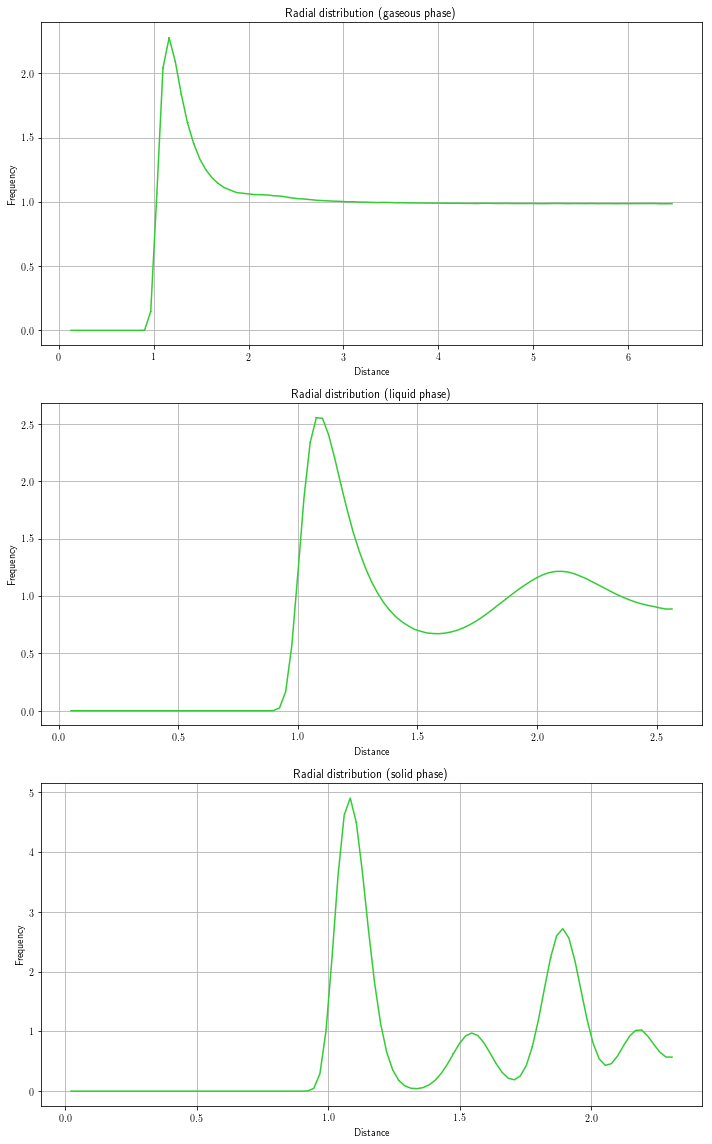

In [15]:
phases = ["gaseous", "liquid", "solid"]
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (10, 16))
axes = axes.flatten()

for (plot_count, phase) in enumerate(phases):
    bins, rd_avg, rd_err = np.loadtxt(prefix + phase + "_output.gave.0", unpack = True, skiprows = 1)
    axes[plot_count].set_title("Radial distribution (" + phase + " phase)")
    axes[plot_count].set_xlabel('Distance')
    axes[plot_count].set_ylabel('Frequency')
    axes[plot_count].errorbar(bins, rd_avg, yerr = rd_err, color = "limegreen")
    axes[plot_count].grid(True)

fig.tight_layout()
plt.show()

#### Exercise 07.4

In [16]:
prefix = "exercise07-4/"

# Physical constants in SI units (arbitrarily approximated...)
boltzmann_constant = 1.381e-23
atomic_mass_unit = 1.661e-27

# Utilities
elements = ["argon", "krypton"]
phases = ["gaseous", "liquid", "solid"]

# Unit scales
length      = {"argon" : 0.34e-9,                   "krypton" : 0.364e-9}
energy      = {"argon" : 120 * boltzmann_constant,  "krypton" : 164 * boltzmann_constant}
mass        = {"argon" : 39.948 * atomic_mass_unit, "krypton" : 83.798 * atomic_mass_unit}

###### Integration with Verlet algorithm
The following plots show some physical quantities measured in a system of particles, whose evolution was simulated using a Verlet algorithm.

###### Potential energy density

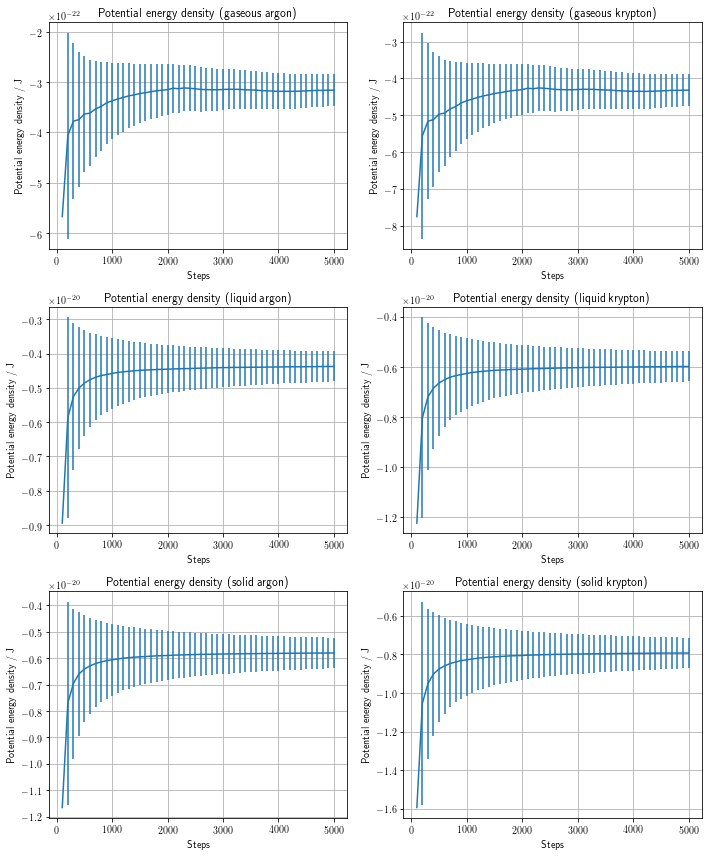

In [17]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 12))
axes = axes.flatten()

for (p_count, phase) in enumerate(phases):
    for (e_count, element) in enumerate(elements):
        steps, avg, err = np.loadtxt(
            prefix + element + "/" + phase + "/output.pot_en.0",
            unpack = True,
            skiprows = 1
        )
        axes[p_count * 2 + e_count].set_title("Potential energy density (" + phase + " " + element + ")")
        axes[p_count * 2 + e_count].set_xlabel('Steps')
        axes[p_count * 2 + e_count].set_ylabel(r'Potential energy density / $\mathrm{J}$')
        SI_unit = energy[element]
        axes[p_count * 2 + e_count].errorbar(steps, avg * SI_unit, yerr = err * SI_unit)
        axes[p_count * 2 + e_count].grid(True)

fig.tight_layout()
plt.show()

###### Pressure

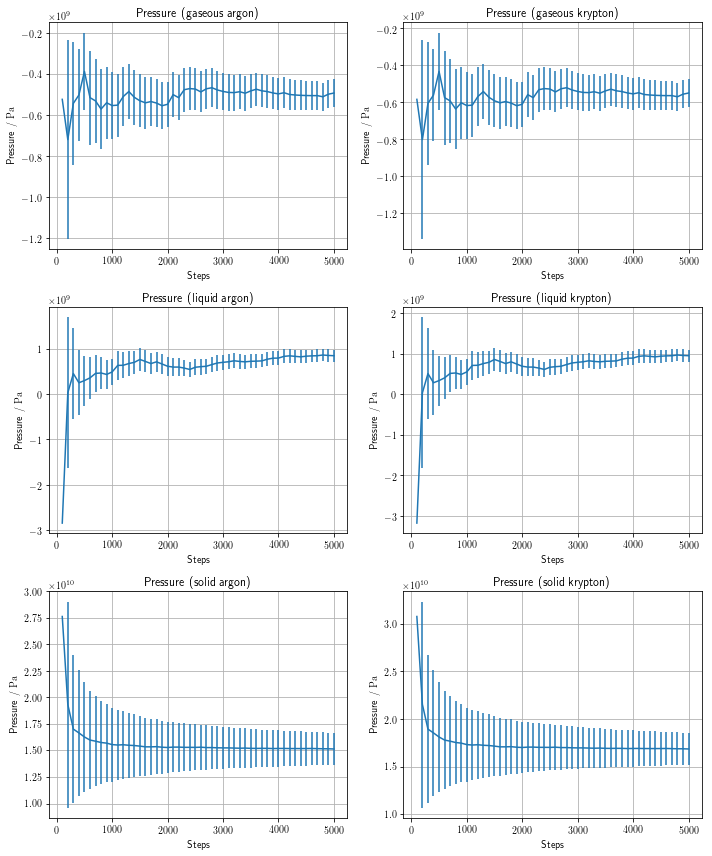

In [18]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 12))
axes = axes.flatten()

for (p_count, phase) in enumerate(phases):
    for (e_count, element) in enumerate(elements):
        steps, avg, err = np.loadtxt(
            prefix + element + "/" + phase + "/output.pressure.0",
            unpack = True,
            skiprows = 1
        )
        axes[p_count * 2 + e_count].set_title("Pressure (" + phase + " " + element + ")")
        axes[p_count * 2 + e_count].set_xlabel('Steps')
        axes[p_count * 2 + e_count].set_ylabel(r'Pressure / $\mathrm{Pa}$')
        SI_unit = energy[element] / length[element]**3
        axes[p_count * 2 + e_count].errorbar(steps, avg * SI_unit, yerr = err * SI_unit)
        axes[p_count * 2 + e_count].grid(True)

fig.tight_layout()
plt.show()

###### Radial distribution function

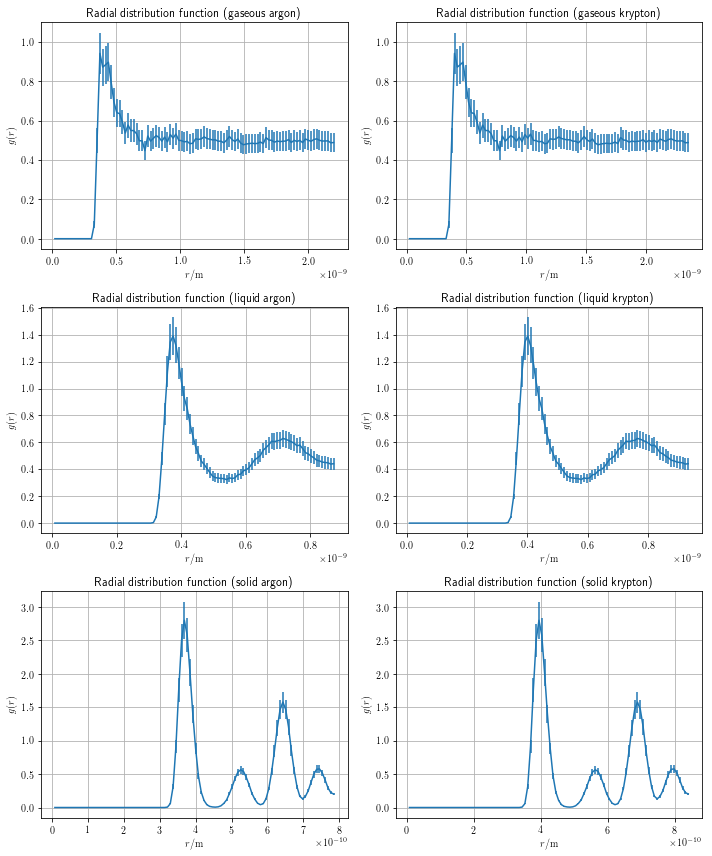

In [19]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 12))
axes = axes.flatten()

for (p_count, phase) in enumerate(phases):
    for (e_count, element) in enumerate(elements):
        distance, avg, err = np.loadtxt(
            prefix + element + "/" + phase + "/output.gave.0",
            unpack = True,
            skiprows = 1
        )
        axes[p_count * 2 + e_count].set_title("Radial distribution function (" + phase + " " + element + ")")
        axes[p_count * 2 + e_count].set_xlabel(r'$r / \mathrm{m}$')
        axes[p_count * 2 + e_count].set_ylabel(r'$g(r)$')
        SI_unit = length[element]
        axes[p_count * 2 + e_count].errorbar(distance * SI_unit, avg, yerr = err)
        axes[p_count * 2 + e_count].grid(True)

fig.tight_layout()
plt.show()

I would say that the plots of the radial distribution functions calculated using the Metropolis algorithm and integrating the equations of motion are equal, apart from the differences in the uncertainties (the integration algorithm used less steps) and the rescaling of the $r$ axis.